In [5]:
!pip install imbalanced-learn


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


In [7]:
df = pd.read_csv('/content/mental-health-in-tech-2016.csv')

# Drop unnecessary columns
df = df.drop(['comments', 'state', 'Timestamp'], axis=1)

# Fix age range
df = df[(df['Age'] >= 18) & (df['Age'] <= 60)]

# Clean gender column
def clean_gender(g):
    g = g.lower()
    if 'male' in g:
        return 'male'
    elif 'female' in g:
        return 'female'
    else:
        return 'other'
df['Gender'] = df['Gender'].apply(clean_gender)

# Drop null rows
df = df.dropna()


In [8]:
# Encode categorical variables
label_enc = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_enc.fit_transform(df[col])

# Create new feature: Risk Score
df['risk_score'] = (
    30 * df['family_history'] +
    25 * df['work_interfere'] +
    20 * df['care_options'] +
    15 * df['benefits'] +
    10 * df['wellness_program']
)

# Normalize
df['risk_score'] = (df['risk_score'] - df['risk_score'].min()) / (df['risk_score'].max() - df['risk_score'].min())

# Create multi-class target: Low, Medium, High risk
def score_to_class(score):
    if score < 0.33:
        return 'low'
    elif score < 0.66:
        return 'medium'
    else:
        return 'high'

df['risk_level'] = df['risk_score'].apply(score_to_class)


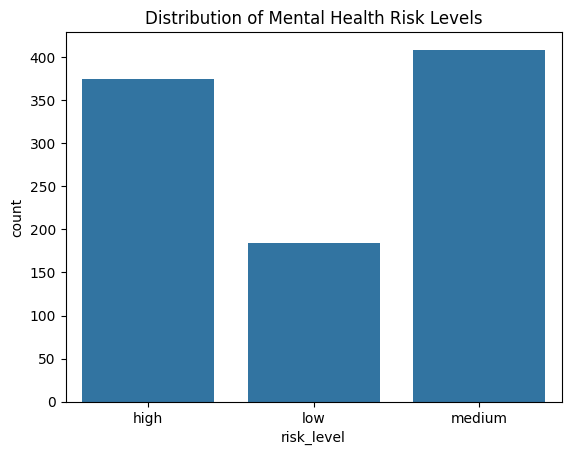

In [9]:
sns.countplot(x='risk_level', data=df)
plt.title("Distribution of Mental Health Risk Levels")
plt.show()


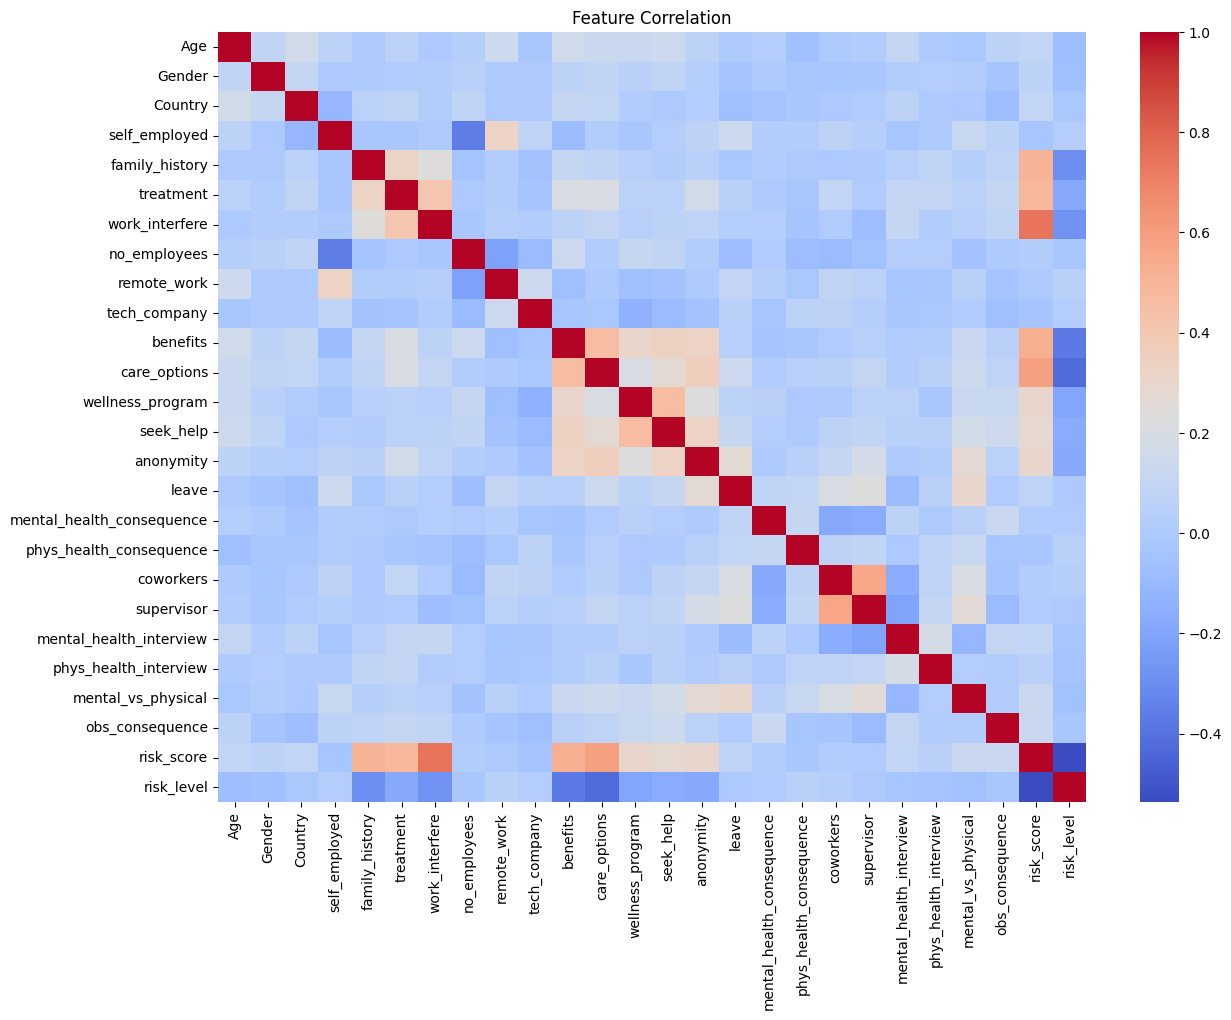

In [11]:
# Encode the 'risk_level' column to numerical values before calculating the correlation
label_enc = LabelEncoder()
df['risk_level'] = label_enc.fit_transform(df['risk_level'])

# Now generate the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [12]:
X = df.drop(['risk_score', 'risk_level'], axis=1)
y = df['risk_level']

# Encode target
y_encoded = label_enc.fit_transform(y)

# Split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)


In [13]:
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Check new class balance
from collections import Counter
print("Balanced classes:", Counter(y_train_resampled))


Balanced classes: Counter({np.int64(0): 327, np.int64(2): 327, np.int64(1): 327})


In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)


Train Accuracy: 1.0000
Test Accuracy: 0.9124
Classification Report:
              precision    recall  f1-score   support

         low       0.93      0.92      0.93        75
      medium       0.94      0.89      0.92        37
        high       0.88      0.91      0.90        82

    accuracy                           0.91       194
   macro avg       0.92      0.91      0.91       194
weighted avg       0.91      0.91      0.91       194



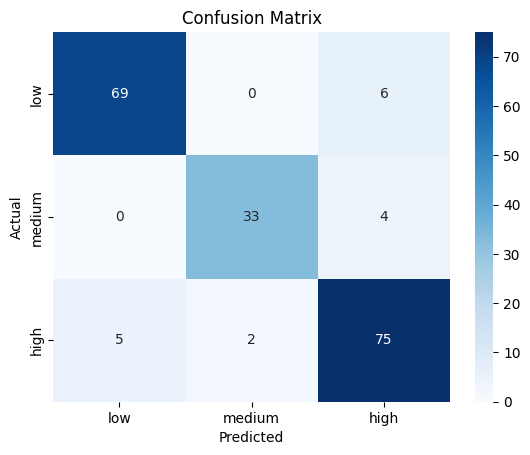

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)

# Calculate and print train accuracy
train_accuracy = rf.score(X_train_resampled, y_train_resampled)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Calculate and print test accuracy
test_accuracy = rf.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['low', 'medium', 'high']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

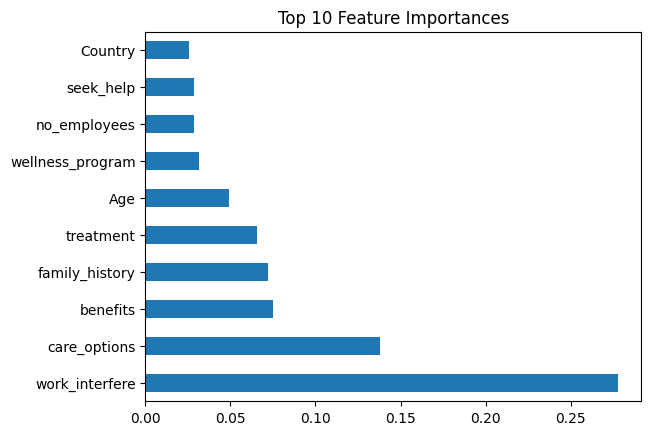

In [18]:
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()


In [20]:
import joblib

# Save your model
joblib.dump(rf, 'mental_health_rf_model.pkl')

# Optional: Save any encoders if used (like LabelEncoder)
joblib.dump(label_enc, 'label_encoder.pkl') # Changed 'label_encoder' to 'label_enc'

['label_encoder.pkl']